# Lesson 3: Connecting to a SQL Database

## Setup

In [1]:
import os
from IPython.display import Markdown, HTML, display
from langchain.chat_models import AzureChatOpenAI
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain_openai import AzureChatOpenAI

## Recover the original dataset

**Note**: To access the data locally, use the following code:

```
os.makedirs("data",exist_ok=True)
!wget https://covidtracking.com/data/download/all-states-history.csv -P ./data/
file_url = "./data/all-states-history.csv"
df = pd.read_csv(file_url).fillna(value = 0)
```

In [2]:
from sqlalchemy import create_engine
import pandas as pd


df = pd.read_csv("./data/all-states-history.csv").fillna(value = 0)

## Move the data to the SQL database

In [3]:
# Path to your SQLite database file
database_file_path = "./db/test.db"

# Create an engine to connect to the SQLite database
# SQLite only requires the path to the database file
engine = create_engine(f'sqlite:///{database_file_path}')
file_url = "./data/all-states-history.csv"
df = pd.read_csv(file_url).fillna(value = 0)
df.to_sql(
    'all_states_history',
    con=engine,
    if_exists='replace',
    index=False
)

20780

## Prepare the SQL prompt

In [4]:
MSSQL_AGENT_PREFIX = """

You are an agent designed to interact with a SQL database.
## Instructions:
- Given an input question, create a syntactically correct {dialect} query
to run, then look at the results of the query and return the answer.
- Unless the user specifies a specific number of examples they wish to
obtain, **ALWAYS** limit your query to at most {top_k} results.
- You can order the results by a relevant column to return the most
interesting examples in the database.
- Never query for all the columns from a specific table, only ask for
the relevant columns given the question.
- You have access to tools for interacting with the database.
- You MUST double check your query before executing it.If you get an error
while executing a query,rewrite the query and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.)
to the database.
- DO NOT MAKE UP AN ANSWER OR USE PRIOR KNOWLEDGE, ONLY USE THE RESULTS
OF THE CALCULATIONS YOU HAVE DONE.
- Your response should be in Markdown. However, **when running  a SQL Query
in "Action Input", do not include the markdown backticks**.
Those are only for formatting the response, not for executing the command.
- ALWAYS, as part of your final answer, explain how you got to the answer
on a section that starts with: "Explanation:". Include the SQL query as
part of the explanation section.
- If the question does not seem related to the database, just return
"I don\'t know" as the answer.
- Only use the below tools. Only use the information returned by the
below tools to construct your query and final answer.
- Do not make up table names, only use the tables returned by any of the
tools below.

## Tools:

"""

In [5]:
MSSQL_AGENT_FORMAT_INSTRUCTIONS = """

## Use the following format:

Question: the input question you must answer.
Thought: you should always think about what to do.
Action: the action to take, should be one of [{tool_names}].
Action Input: the input to the action.
Observation: the result of the action.
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer.
Final Answer: the final answer to the original input question.

Example of Final Answer:
<=== Beginning of example

Action: query_sql_db
Action Input: 
SELECT TOP (10) [death]
FROM covidtracking 
WHERE state = 'TX' AND date LIKE '2020%'

Observation:
[(27437.0,), (27088.0,), (26762.0,), (26521.0,), (26472.0,), (26421.0,), (26408.0,)]
Thought:I now know the final answer
Final Answer: There were 27437 people who died of covid in Texas in 2020.

Explanation:
I queried the `covidtracking` table for the `death` column where the state
is 'TX' and the date starts with '2020'. The query returned a list of tuples
with the number of deaths for each day in 2020. To answer the question,
I took the sum of all the deaths in the list, which is 27437.
I used the following query

```sql
SELECT [death] FROM covidtracking WHERE state = 'TX' AND date LIKE '2020%'"
```
===> End of Example

"""

## Call the Azure Chat model and create the SQL agent

**Note**: The pre-configured cloud resource grants you access to the Azure OpenAI GPT model. The key and endpoint provided below are intended for teaching purposes only. Your notebook environment is already set up with the necessary keys, which may differ from those used by the instructor during the filming.

In [6]:
llm = AzureChatOpenAI(
    openai_api_version="2023-05-15",
    azure_deployment="gpt-4-1106",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    temperature=0, 
    max_tokens=500
)

db = SQLDatabase.from_uri(f'sqlite:///{database_file_path}')
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [7]:
QUESTION = """How may patients were hospitalized during October 2020
in New York, and nationwide as the total of all states?
Use the hospitalizedIncrease column
"""

agent_executor_SQL = create_sql_agent(
    prefix=MSSQL_AGENT_PREFIX,
    format_instructions = MSSQL_AGENT_FORMAT_INSTRUCTIONS,
    llm=llm,
    toolkit=toolkit,
    top_k=30,
    verbose=True
)

## Invoke the SQL model

In [8]:
agent_executor_SQL.invoke(QUESTION)



> Entering new AgentExecutor chain...
To answer this question, I need to find the sum of the `hospitalizedIncrease` column for the state of New York and for all states during October 2020.

Action: sql_db_list_tables
Action Input: albums, all_states_history, artists, customers, employees, genres, invoice_items, invoices, media_types, playlist_track, playlists, tracksThe table that likely contains the data I need for COVID-19 statistics is `all_states_history`.

Action: sql_db_schema
Action Input: all_states_history
CREATE TABLE all_states_history (
	date TEXT, 
	state TEXT, 
	death FLOAT, 
	"deathConfirmed" FLOAT, 
	"deathIncrease" BIGINT, 
	"deathProbable" FLOAT, 
	hospitalized FLOAT, 
	"hospitalizedCumulative" FLOAT, 
	"hospitalizedCurrently" FLOAT, 
	"hospitalizedIncrease" BIGINT, 
	"inIcuCumulative" FLOAT, 
	"inIcuCurrently" FLOAT, 
	negative FLOAT, 
	"negativeIncrease" BIGINT, 
	"negativeTestsAntibody" FLOAT, 
	"negativeTestsPeopleAntibody" FLOAT, 
	"negativeTestsViral" FLOAT, 


{'input': 'How may patients were hospitalized during October 2020\nin New York, and nationwide as the total of all states?\nUse the hospitalizedIncrease column\n',
 'output': 'During October 2020, there were 0 patients hospitalized in New York according to the `hospitalizedIncrease` column, and there were 53,485 patients hospitalized nationwide.'}

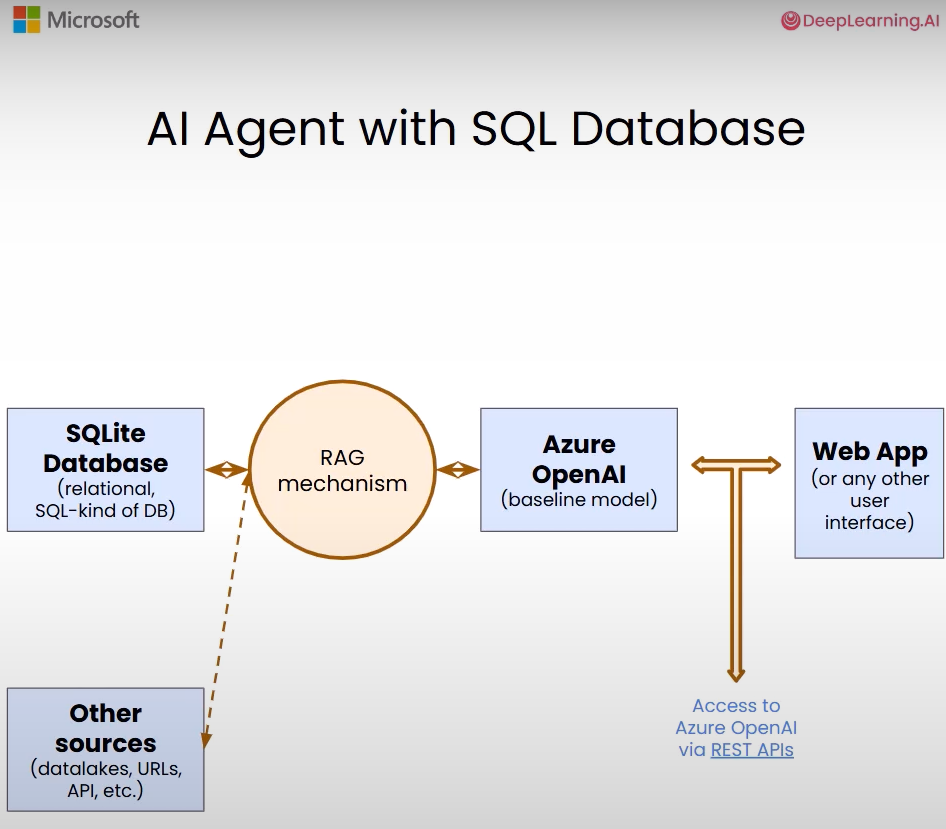

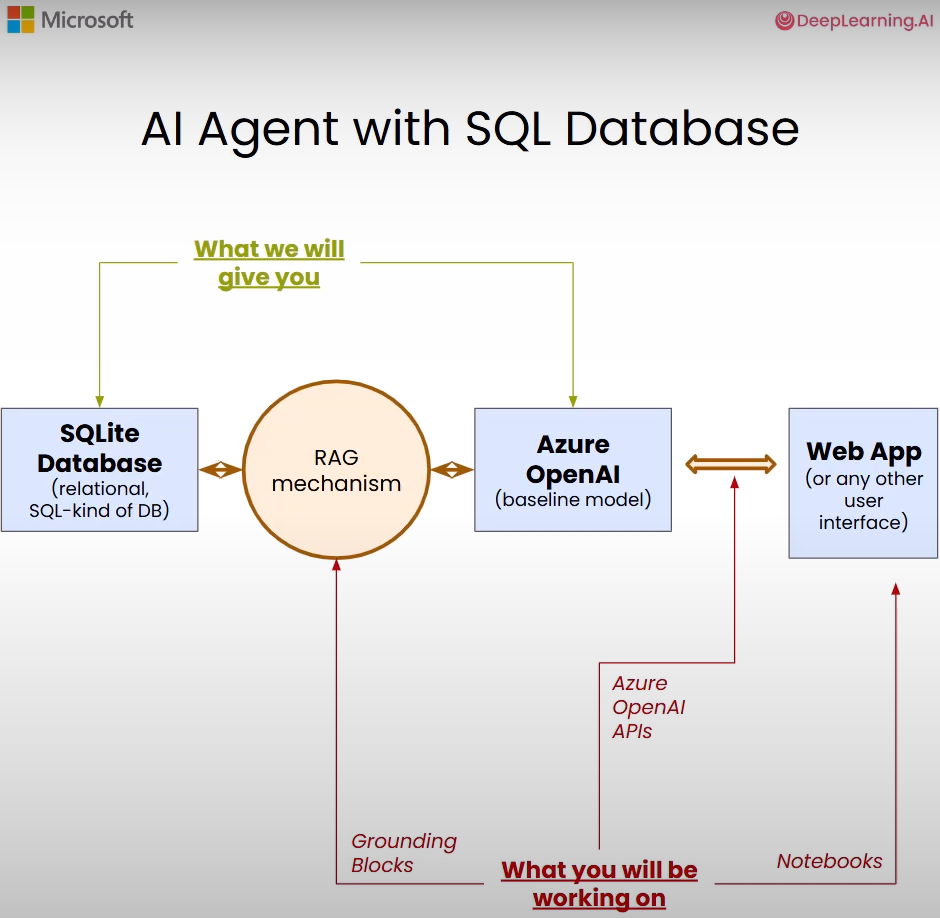